In [ ]:
!pip install --ignore-installed --upgrade tensorflow==1.15

     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 126 kB 58.5 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 503 kB 52.1 MB/s 
     |████████████████████████████████| 1.0 MB 25.9 MB/s 
     |████████████████████████████████| 75 kB 4.0 MB/s 
     |████████████████████████████████| 57 kB 5.2 MB/s 
     |████████████████████████████████| 15.7 MB 50.0 MB/s 
     |████████████████████████████████| 3.8 MB 62.2 MB/s 
     |████████████████████████████████| 4.3 MB 52.1 MB/s 
     |████████████████████████████████| 65 kB 4.4 MB/s 
     |████████████████████████████████| 4.1 MB 65.8 MB/s 
     |████████████████████████████████| 1.1 MB 55.5 MB/s 
     |████████████████████████████████| 224 kB 48.1 MB/s 
     |████████████████████████████████| 97 kB 7.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=1d6

In [ ]:
import tensorflow as tf

import matplotlib

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import numpy as np

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


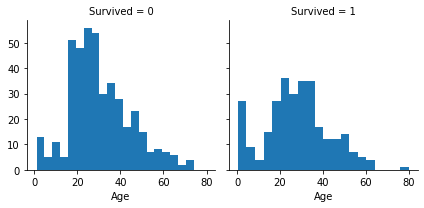

In [ ]:
g = sns.FacetGrid(train, col='Survived')
g.map(plt.hist, 'Age', bins=20)

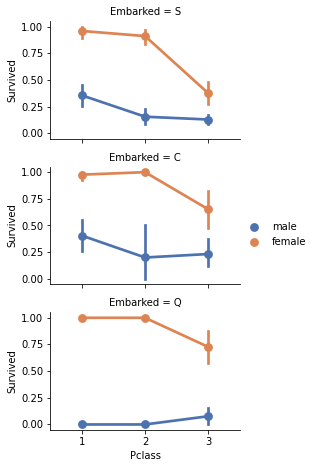

In [ ]:
grid = sns.FacetGrid(train, row='Embarked', height=2.2, aspect=1.6)
# Pointplot으로 시각화, x: 객실 등급, y: 생존 여부, 색깔: 성별, x축 순서: [1, 2, 3], 색깔 순서: [남성, 여성]
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order = [1, 2, 3], hue_order = ["male", "female"])
grid.add_legend()

In [ ]:
combine = [train, test]

In [ ]:
print("Before", train.shape, test.shape)
train = train.drop(['Ticket', 'Cabin'], axis=1)
test = test.drop(['Ticket', 'Cabin'], axis=1)
combine = [train, test]
print("After", train.shape, test.shape)

Before (891, 12) (418, 11)
After (891, 10) (418, 9)


In [ ]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [ ]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


In [ ]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

In [ ]:
train = train.drop(['Name', 'PassengerId'], axis=1)
test = test.drop(['Name'], axis=1)
combine = [train, test]
train.shape, test.shape

((891, 9), (418, 9))

In [ ]:
#성별(Sex) 변수를 숫자 범주형 변수로 바꿔줌
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

In [ ]:
#나이(Age)의 결측치를 자체적으로 예상해서 채우기
guess_ages = np.zeros((2,3))
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()
            # 위에서 guess_ages사이즈를 [2,3]으로 잡아뒀으므로 j의 범위도 이를 따름
            
            age_guess = guess_df.median()

            # age의 random값의 소수점을 .5에 가깝도록 변형
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

In [ ]:
#연령(Age) 변수를 범주형 변수로 바꿔줌
# 임의로 5개 그룹을 지정
train['AgeBand'] = pd.cut(train['Age'], 5)
# 그룹당 생존률 출력
train[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.387500
1,"(16.0, 32.0]",NaN
2,"(32.0, 48.0]",NaN
3,"(48.0, 64.0]",NaN
4,"(64.0, 80.0]",0.090909


In [ ]:
#AgeBand를 바탕으로 Age를 범주형 변수로 바꿔준 후, AgeBand변수는 제거
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train = train.drop(['AgeBand'], axis=1)
combine = [train, test]

In [ ]:
#SibSp와 Parch를 가족과의 동반여부를 알 수 있는 새로운 변수로 통합
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
#통합된 변수당 생존률 출력
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [ ]:
#1은 동반X, 0은 동반했다는 새로운 변수 IsAlone을 생성
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
#새로운 변수당 생존률 출력
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [ ]:
#필요없어진 SibSp, Parch, FamilySize 제거
train = train.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test = test.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train, test]

In [ ]:
#Age변수와 Pclass를 곱한 Age*Class변수 생성
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

In [ ]:
#승선지(Ebmarked) 결측치를 최빈값으로 대체하기
#최빈값 확인
freq_port = train.Embarked.dropna().mode()[0]
freq_port

'S'

In [ ]:
#최빈값으로 대체
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
#승선지별 생존률 출력
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


In [ ]:
#승선지(Ebmarked) 변수를 범주형 변수로 바꿔줌
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [ ]:
#요금(Fare) 변수를 중앙값으로 대체
test['Fare'].fillna(test['Fare'].dropna().median(), inplace=True)
#요금(Fare)을 숫자 범주형 변수로 바꿔줌
train['FareBand'] = pd.qcut(train['Fare'], 4)
train[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

In [ ]:
train = train.drop(['FareBand'], axis=1)
combine = [train, test]

In [ ]:
coeff_df = pd.DataFrame(train.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.153522
5,Title,0.410370
4,Embarked,0.313321
2,Age,0.044285
6,IsAlone,0.042713
3,Fare,-0.038239
7,Age*Class,-0.064162
0,Pclass,-0.977279


훈련 시작

In [ ]:
# 목적 변수 제거
X_train = train.drop("Survived", axis=1)
#목적 변수 역할
Y_train = train["Survived"]
#예측 대상 데이터 셋
X_test  = test.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

79.01

In [ ]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

78.34

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

83.5

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

71.49

In [ ]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

78.68

In [ ]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
print(acc_linear_svc)

78.11


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

72.62

In [ ]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

84.51

In [ ]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

84.51

In [ ]:
#정리
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,84.51
8,Decision Tree,84.51
1,KNN,83.50
2,Logistic Regression,79.01
5,Perceptron,78.68
0,Support Vector Machines,78.34
7,Linear SVC,78.11
6,Stochastic Gradient Decent,72.62
4,Naive Bayes,71.49


In [ ]:
submission = pd.DataFrame({
        "PassengerId": test["PassengerId"],
        "Survived": Y_pred
    })

In [ ]:
#제출
#pred로 예측값을 저장해논 상태
submissionv = pd.read_csv('/content/gender_submission.csv')
submissionv['Survived'] = Y_pred
submissionv.to_csv('sub.csv',index=False)